In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import numpy as np
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random


In [3]:
#DATASET PRE-PROCESSING

batch_size  = 32
random_seed = 10
random.seed(random_seed)
torch.manual_seed(random_seed)

#Import dataset from the local folder and change it to an appropriate tensor shape. 
from torchvision import transforms, datasets
data_path = '/gdrive/MyDrive/CS470/Final_Proj/Dataset (1)'  
foot_dataset = datasets.ImageFolder(data_path, transforms.Compose([
                                                    transforms.Resize((224, 224)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                                    ]))
                            

#Splitting the data so that we have a validation set with size = size(dataset)*0.2
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
train_idx, valid_idx = train_test_split(list(range(len(foot_dataset))), test_size=0.2, random_state=random_seed)
datasets = {}
datasets['train'] = Subset(foot_dataset, train_idx)
datasets['valid'] = Subset(foot_dataset, valid_idx)

#Defining the dataloader in order to put data in to the model

dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'], batch_size=batch_size, shuffle=False, num_workers=4)

from pathlib import Path
root = '/gdrive/MyDrive/CS470/Final_Proj/'
data_dir = Path(root) / 'dataloaders'
torch.save(dataloaders['train'], data_dir / f'train.pth')
torch.save(dataloaders['valid'], data_dir/ f'valid.pth')
batch_num['train'], batch_num['valid'] = len(dataloaders['train']), len(dataloaders['valid'])
print('batch_size : %d,  tvt : %d / %d' % (batch_size, batch_num['train'], batch_num['valid']))

batch_size : 32,  tvt : 150 / 38


In [4]:
#Check whether the classes are well assigned.
foot_dataset.classes

['0. Foot1',
 '1. Foot2',
 '2. Foot3',
 '3. Foot4',
 '4. Foot5',
 '5. Foot6',
 '6. Foot7',
 '7. Foot8',
 '8. Foot9',
 '9. Foot10',
 'a. Foot11',
 'b. Foot12',
 'c. Foot13',
 'd. Foot14',
 'e. Foot15']

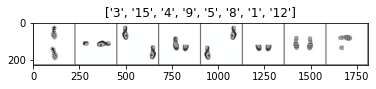

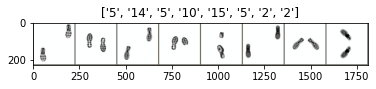

In [5]:
#DATA VALIDATION: CHECKING IF THE DATA is well classified to the desired classes

import torchvision

#This function gets the input and calls the matplolib plot, with the images.
def imshow(x, title=None):
    x = x.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = std * x + mean
    x = np.clip(x, 0, 1)
    plt.imshow(x)
    if title is not None:
        plt.title(title)
    #Prevent Crashing when uploading!
    plt.pause(0.1) 

num_img = 8

class_names = {
    "0": "1",      
    "1": "2",  
    "2": "3",  
    "3": "4",  
    "4": "5",  
    "5": "6",   
    "6": "7" ,
    "7": "8" ,
    "8": "9",
    "9": "10",
    "10": "11",
    "11": "12",
    "12": "13",
    "13": "14",
    "14": "15" ,  
}

# train check
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:num_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_img]])
# valid check
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:num_img])  
imshow(out, title=[class_names[str(int(x))] for x in classes[:num_img]])


In [6]:
!git clone https://github.com/harryoh99/Efficient_Net


fatal: destination path 'Efficient_Net' already exists and is not an empty directory.


In [7]:
cd Efficient_Net/

/content/Efficient_Net


In [8]:
pip install -e .

Obtaining file:///content/Efficient_Net
  Found existing installation: efficientnet-pytorch 0.7.0
    Can't uninstall 'efficientnet-pytorch'. No files were found to uninstall.
  Running setup.py develop for efficientnet-pytorch


In [9]:
from efficientnet_pytorch import EfficientNet

#Directory where the model will be saved.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)


model_name = 'efficientnet-b0'  # b5
image_size = EfficientNet.get_image_size(model_name)
#print(image_size) -> 224

#Bringing the pre-trained Network (pre-trained by the ImageNet)
model = EfficientNet.from_pretrained(model_name, num_classes=15)



#Training the Model
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    start_time = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}:'.format(epoch))
        print('-----------------------------------------------')

        # Each epoch has a training and validation mode
        for mode in ['train', 'valid']:
            if mode == 'train':
                model.train()  # Model will be set to a training mode.
            else:
                model.eval()   # Model will be set to a test(evaluation mode)->exclude batch norm, dropout etc..

            epoch_tot_loss, epoch_tot_acc, cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[mode]:
                inputs = inputs.to(device) #gpu
                labels = labels.to(device) #gpu

                # Initialize Gradient Parameters (to zero)
                optimizer.zero_grad()

                # Forward Porcess
                # Gradient tracking should be only be done when mode==train for fast process
                with torch.set_grad_enabled(mode == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    # Backward propogation should be done only when it is training mode.
                    if mode == 'train':
                        loss.backward()
                        optimizer.step()

                # Trying to save the loss for ach Epoch
                epoch_tot_loss += loss.item() * inputs.size(0)
                epoch_tot_acc += torch.sum(preds == labels.data)
                cnt += len(labels)
            
            if mode == 'train':
                scheduler.step()
            

            epoch_loss = float(epoch_tot_loss / cnt)
            epoch_acc  = float((epoch_tot_acc.double() / cnt).cpu()*100)
            
            if mode == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
            print('{} Loss: {:.2f} Acc: {:.1f}'.format(mode, epoch_loss, epoch_acc))
           
            # Deep copy the model -> want to save the model that has the best accuracy
            # Compare the best accuracy from the previous models
            if mode == 'valid' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %dth Model - %.1f' %(best_idx, best_acc))

    #Load best model weights
    model.load_state_dict(best_model)
    torch.save(model.state_dict(), result_dir / f'best.pt')
    print('Model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

Loaded pretrained weights for efficientnet-b0


In [10]:
#Want to see the Results Visualized if the model is actually well classified to the desired classes for the validation sets!

def visualize_model(model, class_names,num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[str(preds[j].item())]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
torch.cuda.empty_cache()

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_fin = optim.SGD(model.parameters(),  lr = 0.025, momentum=0.9, weight_decay=1e-4)

lmbda = lambda epoch: 0.99
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_fin, lr_lambda=lmbda)

Epoch 0:
-----------------------------------------------
train Loss: 0.90 Acc: 66.1
valid Loss: 0.68 Acc: 77.0
Epoch 1:
-----------------------------------------------
train Loss: 0.06 Acc: 98.4
valid Loss: 0.20 Acc: 92.7
Epoch 2:
-----------------------------------------------
train Loss: 0.02 Acc: 99.4
valid Loss: 0.02 Acc: 99.5
Epoch 3:
-----------------------------------------------
train Loss: 0.02 Acc: 99.3
valid Loss: 0.32 Acc: 88.9
Epoch 4:
-----------------------------------------------
train Loss: 0.02 Acc: 99.4
valid Loss: 0.19 Acc: 95.2
Epoch 5:
-----------------------------------------------
train Loss: 0.01 Acc: 99.7
valid Loss: 0.03 Acc: 99.1
Epoch 6:
-----------------------------------------------
train Loss: 0.01 Acc: 99.9
valid Loss: 0.00 Acc: 100.0
Epoch 7:
-----------------------------------------------
train Loss: 0.00 Acc: 100.0
valid Loss: 0.00 Acc: 100.0
Epoch 8:
-----------------------------------------------
train Loss: 0.00 Acc: 99.9
valid Loss: 0.00 Acc: 100

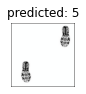

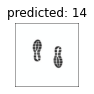

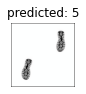

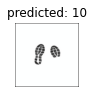

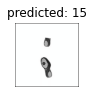

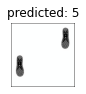

In [13]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_fin, exp_lr_scheduler, num_epochs=10)
visualize_model(model,class_names)

best model : 6th Model - Accuracy: 100, Loss: 0.0


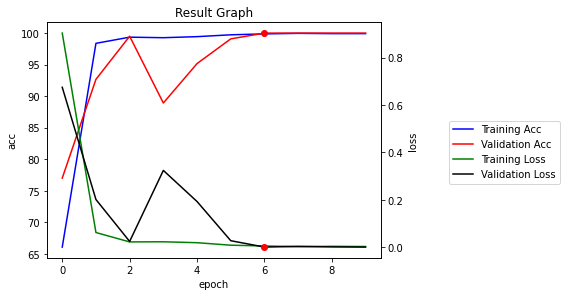

In [14]:
print('best model : %dth Model - Accuracy: %1.f, Loss: %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-', label ='Training Acc')
ax1.plot(valid_acc, 'r-', label = 'Validation Acc')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')

ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-', label = 'Training Loss')
ax2.plot(valid_loss, 'k-', label = 'Validation Loss')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
fig.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.title("Result Graph")
plt.show()

